In [1]:

import sys
from multiprocessing import Process
from os.path import join

sys.path.append('../')
sys.path.append('../../')

from omegaconf import OmegaConf
from src.utils.run_lib import *
from src.utils.conf_utils import * 

calib_val_frac = 0.5

root_dir = '../../'
conf_dir = f'{root_dir}configs/calib-exp/'

method = 'passive_learning'

model_ds_key = 'synthetic_2d_moons'

root_pfx = f'test_runs/{model_ds_key}_calib/'

base_conf                = OmegaConf.load(f'{conf_dir}/{model_ds_key}_base_conf_torch.yaml')
base_conf['output_root'] = join(root_dir, 'outputs', root_pfx)

base_conf['eval'] = 'full'
base_conf['root_pfx'] = root_pfx
base_conf['calib_conf'] = None 


base_conf['method'] = method #'passive_learning' # single round
#base_conf['method'] = 'active_labeling'  # multi round
#base_conf['training_conf']['weight_decay'] = 0.001

base_conf['val_pts_query_conf']['max_num_val_pts'] = 100

base_conf['train_pts_query_conf']['max_num_train_pts'] = 100

run_train_time = True   
run_post_hoc   = False 

all_outs = []

In [2]:

def augment_conf(conf):
    calib_conf = conf['calib_conf']
    if(calib_conf!=None):
        conf['run_dir']        = join(conf['output_root'], calib_conf['name'])
    else:
        conf['run_dir']        = join(conf['output_root'], "None")
    
    
    if(calib_conf and (calib_conf['type']=='post_hoc')):
        ckpt_file_name = get_model_ckpt_file_name(conf)

        conf.training_conf['save_ckpt'] = True 
        conf.training_conf['train_from_scratch'] = False  
        conf.training_conf['ckpt_save_path'] = join(root_dir, 'ckpt', ckpt_file_name)
        conf.training_conf['ckpt_load_path'] = join(root_dir, 'ckpt', ckpt_file_name)

    if( calib_conf and  (calib_conf['type']=='train_time')):
        for k in  calib_conf.training_conf.keys():
            conf.training_conf[k] = calib_conf.training_conf[k]

        ckpt_file_name = get_model_ckpt_file_name(conf)

        conf.training_conf['ckpt_save_path'] = f'{root_dir}/ckpt/{ckpt_file_name}'

    conf['log_file_path']  = join(conf['run_dir'], conf['method'] + '.log')
    conf['out_file_path']  = join(conf['run_dir'], conf['method'] + '.pkl')
    conf['conf_file_path'] = join(conf['run_dir'], conf['method'] + '.yaml')

    return conf 


In [3]:
data_conf = base_conf['data_conf']

data_conf['train_set_size'] = 10000
data_conf['dimension'] = 2 
data_conf['val_fraction'] = 0.3
data_conf['test_set_size'] = 4000

model_conf = base_conf['model_conf']
model_conf["input_dimension"] = 2 

conf = base_conf 

augment_conf(conf)


{'random_seed': 1, 'device': 'cuda:0', 'lib': 'pytorch', 'data_conf': {'name': 'synth_moon', 'train_set_size': 10000, 'dimension': 2, 'val_fraction': 0.3, 'num_classes': 2, 'test_set_size': 4000, 'random_state': 0}, 'model_conf': {'name': 'dynamic_mlp', 'input_dimension': 2, 'output_dimension': 2, 'layers': [{'type': 'linear', 'dim_factor': 10}, {'type': 'activation', 'act_fun': 'tanh'}, {'type': 'linear', 'dim_factor': 10}, {'type': 'activation', 'act_fun': 'tanh'}], 'num_classes': 2, 'fit_intercept': True, 'lib': 'pytorch'}, 'training_conf': {'loss_function': 'std_cross_entropy', 'optimizer': 'sgd', 'momentum': 0.9, 'weight_decay': 0.0001, 'learning_rate': 0.1, 'loss_tolerance': 1e-06, 'max_epochs': 20, 'normalize_weights': False, 'batch_size': 64, 'train_err_tol': -1, 'ckpt_load_path': 'None', 'ckpt_save_path': 'None', 'train_from_scratch': True, 'train_from_ckpt': False}, 'inference_conf': None, 'train_pts_query_conf': {'seed_train_size': 32, 'query_batch_size': 16, 'query_strategy

In [4]:

overwrite = True 

if('calib_conf' in conf and conf['calib_conf'] not in [None, "None"]):
    conf['calib_conf']['device'] = conf['device']

if(not overwrite):
    if(os.path.exists(conf['out_file_path'])):
        print(f"path exists {conf['out_file_path']}")
try:
    os.makedirs(conf['run_dir'])
except OSError:
    pass

ckpt_save_path = conf.training_conf['ckpt_save_path'] 

if(ckpt_save_path) :
    #check if ckpt_save_path directories exist, if not create.
    ckpt_dir_path  = os.path.sep.join( ckpt_save_path.split(os.path.sep)[:-1])

    try:
        os.makedirs(ckpt_dir_path)
    except OSError:
        pass

set_defaults(conf)

conf['inference_conf']['device'] = conf['device']

if('conf_file_path' in conf):
    with open(conf['conf_file_path'],'w') as f:
            OmegaConf.save(config=conf, f=f)

logger = get_logger(conf['log_file_path'],stdout_redirect=True,level=logging.DEBUG)


In [5]:
def run_conf_2(conf):
    set_seed(conf['random_seed'])
    # get data
    dm = DataManager(conf,logger, lib=conf['model_conf']['lib'])

    logger.info('Loaded dataset {}'.format(conf['data_conf']['name']))
    logger.info(f' std_train_size : {len(dm.ds_std_train)} and  std_val_size: {len(dm.ds_std_val)}')

    pas_learn = PassiveLearning(conf,dm,logger)

    out = pas_learn.run()

    auto_lbl_conf = conf['auto_lbl_conf']

    auto_lbl_conf['method_name']= 'selective' 

    #<<<<<<<<<<<<<<<<<<<<<<<<< BEGIN CALIBRATION BLOCK <<<<<<<<<<<<<<<<<<<<<<<<<
    cur_calibrator = None 
    if( conf['calib_conf'] and conf['calib_conf']['type']=='post_hoc'):
        calib_conf    = conf['calib_conf'] 
        logger.info('========================= Training Post-hoc Calibrator   =========================')
        
        logger.info(f"Calib Conf : {conf['calib_conf']}")

        cur_calibrator  = get_calibrator(pas_learn.cur_clf,calib_conf,logger)

        # randomly split the current available validation points into two parts.
        # one part will be used for training the calibrator and other part for finding 
        # the auto-labeling thresholds.
        dm.select_calib_val_points(calib_frac=calib_conf['calib_val_frac'])
        
        cur_val_ds_c , cur_val_idcs_c    = dm.get_cur_calib_val_ds()
        cur_val_ds_nc , cur_val_idcs_nc    = dm.get_cur_non_calib_val_ds()

        #print(np.histogram(cur_val_ds_c.Y.numpy()))

        values, counts = np.unique(cur_val_ds_c.Y.numpy(), return_counts=True)
        print(values)
        print(counts)

        logger.info(f"Number of validation points for training calibrator : {len(cur_val_idcs_c)}")
        cur_calibrator.fit(cur_val_ds_c,ds_val_nc=cur_val_ds_nc)
    else:
        logger.info('=========================    No Post-hoc Calibration     =========================')
        cur_calibrator = None 

    #>>>>>>>>>>>>>>>>>>>>>>>>>>> END CALIBRATION BLOCK  >>>>>>>>>>>>>>>>>>>>>>>>>>>

    auto_labeler = AutoLabeling(conf,dm,pas_learn.cur_clf,logger,cur_calibrator)
    out = auto_labeler.run()
    counts_sel = dm.get_auto_labeling_counts()


    logger.info(f" Selective Auto-labeling counts: {counts_sel}")

    counts_sel['avg_ece_on_val'] =  out['ECE_on_val'] if 'ECE_on_val' in out else None
    counts_sel['avg_ece_no_calib_on_val'] = out['ECE_on_val_no_calib'] if 'ECE_on_val_no_calib' in out else None

    return pas_learn,cur_calibrator, dm, counts_sel

In [6]:
pl, calib, dm, counts = run_conf_2(conf)

[01/09/2024 09:10:01 PM : DEBUG : data_manag : ] : (7000, 2)
[01/09/2024 09:10:01 PM : INFO  : data_manag : ] : Loaded dataset synth_moon
[01/09/2024 09:10:01 PM : INFO  : data_manag : ] : Std train size: 7000 and Std. Val. Size:3000
[01/09/2024 09:10:01 PM : INFO  : 4221643277 : ] : Loaded dataset synth_moon
[01/09/2024 09:10:01 PM : INFO  : 4221643277 : ] :  std_train_size : 7000 and  std_val_size: 3000
[01/09/2024 09:10:01 PM : DEBUG : passive_le : ] : Querying 32 seed training points
[01/09/2024 09:10:01 PM : DEBUG : passive_le : ] : Queried 32 seed points for training
[01/09/2024 09:10:01 PM : DEBUG : passive_le : ] : Validation Data Size :100
[01/09/2024 09:10:01 PM : DEBUG : passive_le : ] : Querying rest of the training points 68 in single batch
[01/09/2024 09:10:01 PM : INFO  : passive_le : ] : Labeled data size for training: 100
[01/09/2024 09:10:01 PM : INFO  : passive_le : ] : Labeled data size for validation: 100
[01/09/2024 09:10:01 PM : INFO  : model_fact : ] : {'name': 

In [121]:
def visualize(ax,ax_scores_dist,cur_clf, cur_calibrator, dm, normalize=False):

    def get_grid_pts(x_min,x_max, y_min, y_max,step=0.005):
        xx, yy = np.mgrid[x_min:x_max:step, y_min:y_max:step]
        positions = np.vstack([xx.ravel(), yy.ravel()]).T 
        return positions

    X = get_grid_pts(-1.25,2.25,-1,1.5)

    Y = torch.zeros(len(X)).long()
    X = torch.Tensor(X)
    X_ = torch.zeros((len(X),2))

    ds = CustomTensorDataset(X=X,Y=Y)
    if(cur_calibrator):
        inf_out = cur_calibrator.predict(ds,inference_conf={"batch_size":100, "device":conf["device"]})
    else:
        inf_out = cur_clf.predict(ds,inference_conf={"batch_size":100, "device":conf["device"]})


    X = safe_to_numpy(X)
    Y = safe_to_numpy(Y)
    g = safe_to_numpy(inf_out['confidence'])
    g[np.isnan(g)]=0.0


    
    y_hat = safe_to_numpy(inf_out['labels'])
    idx = np.arange(0,len(g),1)

    '''
    #idx_ = torch.where((g > 0.45) & (g < 0.55), idx)
    idx_ = idx[(g > 0.48) & (g < 0.52)]

    X_ = X[idx_]
    
    ax.scatter(X_[:,0],X_[:,1],s=0.3)
    '''

    cmap_neg = plt.cm.Reds

    neg_idx = idx[ y_hat==0 ]
    #colors_neg = cmap_neg(0.6*g[neg_idx] / g[neg_idx].max())
    
    g_ = g[neg_idx]

    if(normalize):
        g_ = g_ - min(g_)
        g_ = g_/max(g_)
    
    colors_neg = cmap_neg(g_)

    print(np.mean(g[neg_idx]),np.std(g[neg_idx]))

    ax.scatter(X[neg_idx,0],X[neg_idx,1],s=0.1,c=colors_neg)


    cmap_pos = plt.cm.Blues
    pos_idx = idx[ y_hat==1 ]
    
    
    g_ = g[pos_idx]

    if(normalize):
        g_ = g_ - min(g_)
        g_ = g_/max(g_)
    
    colors_pos = cmap_pos(g_)

    print(np.mean(g[pos_idx]),np.std(g[pos_idx]))

    ax.scatter(X[pos_idx,0],X[pos_idx,1],s=0.1,c=colors_pos)

    X,Y = dm.ds_std_train.X ,  dm.ds_std_train.Y
    idx = np.arange(0,len(X),1)

    pos_idx = idx[ Y==1 ]
    neg_idx = idx[ Y==0 ]
    pos_idx = np.random.choice(pos_idx,500,replace=False)
    neg_idx = np.random.choice(neg_idx,500,replace=False)

    ax.scatter(X[pos_idx,0], X[pos_idx,1], color='blue', s=0.1)
    ax.scatter(X[neg_idx,0], X[neg_idx,1], color='red',  s=0.1)

    inf_out_train_ds = None 

    dm.ds_std_train= tensorize(dm.ds_std_train)
    
    if(cur_calibrator):
        inf_out_train_ds = cur_calibrator.predict(dm.ds_std_train,inference_conf={"batch_size":100, "device":conf["device"]})
    else:
        inf_out_train_ds = cur_clf.predict(dm.ds_std_train,inference_conf={"batch_size":100, "device":conf["device"]})
    
    y_hat = safe_to_numpy(inf_out_train_ds['labels'])
    Y= Y.numpy()
    correct_idcs = idx[y_hat==Y]
    incorrect_idcs = idx[y_hat!=Y]
    scores = safe_to_numpy(inf_out_train_ds['confidence'])
    #sns.histplot(np.clip(scores[correct_idcs],0,1),ax=ax_scores_dist)
    #sns.histplot(np.clip(scores[incorrect_idcs],0,1),ax=ax_scores_dist)

    if(normalize):
        scores = scores - min(scores)
        scores = scores/max(scores)
    
    h1, edges1 = np.histogram(scores[correct_idcs],bins=15,density=True)
    h1 = h1/np.sum(h1)
    h2, edges2 = np.histogram(scores[incorrect_idcs],bins=15,density=True)
    h2 = h2/np.sum(h2)
    ax_scores_dist.bar(edges1[1:], height=h1, width=0.01,color='blue')
    ax_scores_dist.bar(edges2[1:], height=h2, width=0.01,color='red')
    
    
    
    #sns.kdeplot(np.clip(scores[correct_idcs],0,1),ax=ax_scores_dist, clip=(0,1.05))
    #sns.kdeplot(np.clip(scores[incorrect_idcs],0,1),ax=ax_scores_dist, clip=(0,1.05))
    
    ax_scores_dist.set_xlim(-0.1,1.1)
    print(h1)
    print(h2)
    ax_scores_dist.set_ylim(0,max(max(h1),max(h2)))

    


0.9271098 0.11689159
0.93875366 0.11320035
[0.00829268 0.01056912 0.00910569 0.01105691 0.01284555 0.01186992
 0.01398374 0.01430897 0.01804878 0.01756097 0.02471549 0.03658536
 0.04439023 0.08276435 0.68390226]
[0.06352947 0.05647053 0.07176477 0.05999994 0.05882358 0.06117641
 0.06235299 0.05647053 0.06235299 0.05647053 0.07529418 0.08941167
 0.09058831 0.07647051 0.05882358]


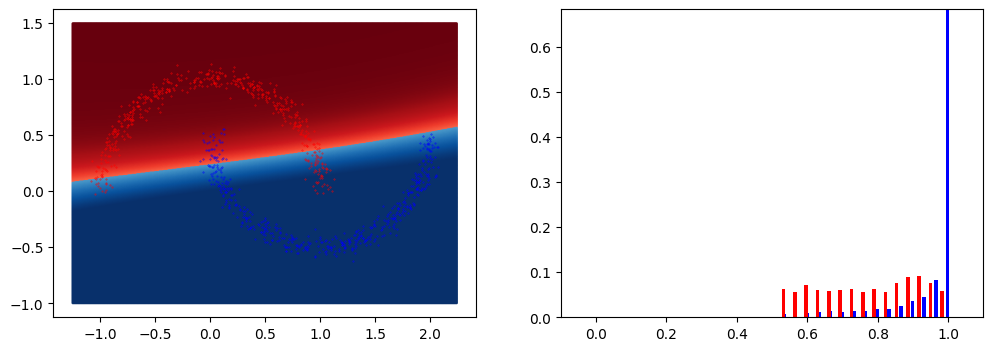

In [119]:

fig, axs = plt.subplots(1, 2,figsize=(12, 4))

visualize(axs[0],axs[1],pl.cur_clf,cur_calibrator=None,dm=dm)

In [115]:
conf['calib_conf'] = OmegaConf.load(f'{conf_dir}/post-hoc/auto_lbl_opt_v0_conf.yaml')

calib_conf = conf['calib_conf']

calib_conf['l1']=1.0 
calib_conf['l2']=1000.0 # 3 or 5
calib_conf['l3']=0.0  #1.0
calib_conf['l4']=0.0
calib_conf['calib_val_frac'] = calib_val_frac 

#calib_conf['features_key']  = 'logits'
#calib_conf['features_key']  = 'pre_logits'
calib_conf['features_key']  = 'logits'

#calib_conf['class_wise'] = 'joint'
calib_conf['class_wise'] = 'independent'
#calib_conf['class_wise'] ="joint_g_independent_t"
model = "two_layer"
#model = "linear" 
calib_conf['num_classes'] = 2 


if(model=="two_layer"):
    model_conf = OmegaConf.load('{}/model_confs/two_layer_net_base_conf.yaml'.format(conf_dir))

    model_conf.layers[0]['dim_factor']=2
    model_conf.layers[1]['act_fun']='tanh'

else:
    model_conf = {} 

model_conf['num_classes'] = 2

calib_conf['model_conf'] = model_conf 


#calib_conf['regularize'] = False  
calib_conf['regularize'] = True 
calib_conf['auto_lbl_conf'] = conf.auto_lbl_conf


#calib_conf['features_key']  = 'logits'

#calib_conf['alpha_1'] = 0.0001 #/1.5
calib_conf['alpha_1'] =0.001 #/1.5

calib_conf['training_conf_g']['batch_size'] = 100  # 64

calib_conf['training_conf_g']['optimizer'] = 'adam'
calib_conf['training_conf_g']['learning_rate'] = 1e-1
calib_conf['training_conf_g']['weight_decay'] =  1.0

calib_conf['training_conf_t']['optimizer'] = 'adam'
calib_conf['training_conf_t']['learning_rate'] = 1e-1
calib_conf['training_conf_t']['weight_decay'] = 1.0


calib_conf['training_conf_g']['max_epochs'] = 1000


In [112]:
def safe_to_numpy(x):
    if(torch.is_tensor(x)):
        return x.numpy()
    else:
        return x 

In [66]:
pl2, calib2, dm2, counts = run_conf_2(conf)

[01/09/2024 09:38:56 PM : DEBUG : data_manag : ] : (7000, 2)
[01/09/2024 09:38:56 PM : INFO  : data_manag : ] : Loaded dataset synth_moon
[01/09/2024 09:38:56 PM : INFO  : data_manag : ] : Std train size: 7000 and Std. Val. Size:3000
[01/09/2024 09:38:56 PM : INFO  : 4221643277 : ] : Loaded dataset synth_moon
[01/09/2024 09:38:56 PM : INFO  : 4221643277 : ] :  std_train_size : 7000 and  std_val_size: 3000
[01/09/2024 09:38:56 PM : DEBUG : passive_le : ] : Querying 32 seed training points
[01/09/2024 09:38:56 PM : DEBUG : passive_le : ] : Queried 32 seed points for training
[01/09/2024 09:38:56 PM : DEBUG : passive_le : ] : Validation Data Size :100
[01/09/2024 09:38:56 PM : DEBUG : passive_le : ] : Querying rest of the training points 68 in single batch
[01/09/2024 09:38:56 PM : INFO  : passive_le : ] : Labeled data size for training: 100
[01/09/2024 09:38:56 PM : INFO  : passive_le : ] : Labeled data size for validation: 100
[01/09/2024 09:38:56 PM : INFO  : model_fact : ] : {'name': 

0.9271098 0.11689159
0.93875366 0.11320035
[0.00829268 0.01056912 0.00910569 0.01105691 0.01284555 0.01186992
 0.01398374 0.01430897 0.01804878 0.01756097 0.02471549 0.03658536
 0.04439023 0.08276435 0.68390226]
[0.06352947 0.05647053 0.07176477 0.05999994 0.05882358 0.06117641
 0.06235299 0.05647053 0.06235299 0.05647053 0.07529418 0.08941167
 0.09058831 0.07647051 0.05882358]
0.5231665 0.002564801
0.46470365 0.0030055095
[0.14439016 0.11105684 0.06764249 0.04601623 0.04097558 0.03430892
 0.03300811 0.02699195 0.0320325  0.03886177 0.04016258 0.04878046
 0.06715468 0.10731701 0.16130072]
[0.00588235 0.04235294 0.05176471 0.0717647  0.07529412 0.07647059
 0.11411765 0.15176466 0.09176475 0.07529409 0.08352939 0.07058827
 0.05882356 0.02588234 0.00470588]


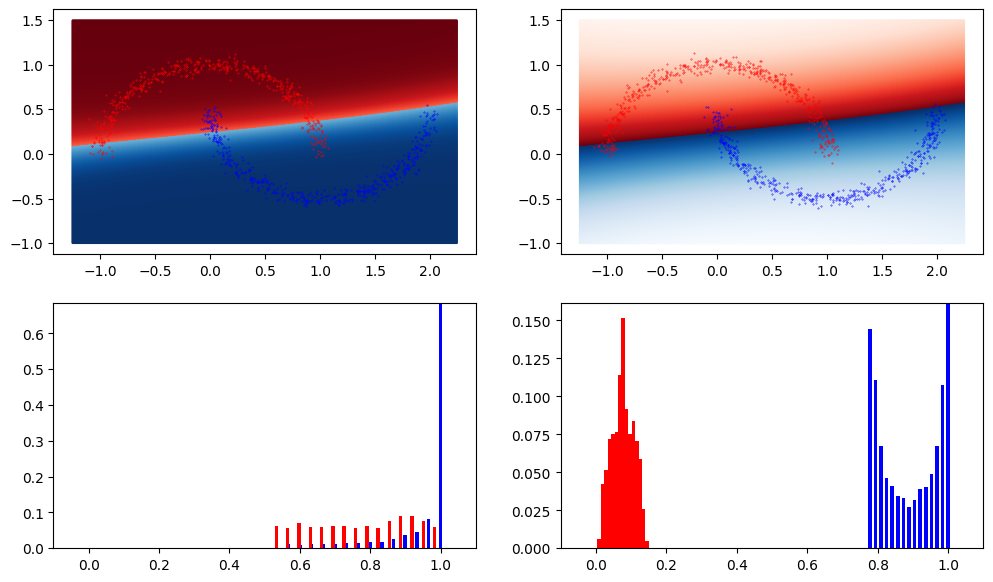

In [122]:
#plt.figure(figsize=(,5))
#ax = plt.subplots(nrows=1, ncols=2)
#plt.figure(figsize=(18, 6), dpi=80)
fig, axs = plt.subplots(2, 2,figsize=(12, 7))

visualize(axs[0][0],axs[1][0],pl.cur_clf,calib,dm)

visualize(axs[0][1],axs[1][1],pl2.cur_clf,calib2,dm2,normalize=True)


In [131]:
def f(x, y):
    return np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 40)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
print(X.shape , Z.shape , Y.shape)


(40, 50) (40, 50) (40, 50)


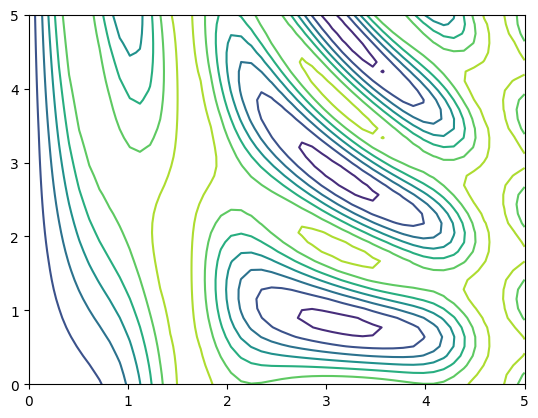

In [129]:
plt.contour(X, Y, Z)

In [158]:
def visualize_db2(ax,ax_scores_dist,cur_clf, cur_calibrator, dm, normalize=False):

    def get_grid_pts(x_min,x_max, y_min, y_max,step=0.005):
        xx, yy = np.mgrid[x_min:x_max:step, y_min:y_max:step]

        positions = np.vstack([xx.ravel(), yy.ravel()]).T 
        return positions,xx,yy 

    X,xx,yy = get_grid_pts(-1.25,2.25,-1,1.5)
    print(xx.shape,yy.shape)

    Y = torch.zeros(len(X)).long()
    X = torch.Tensor(X)
    X_ = torch.zeros((len(X),2))

    ds = CustomTensorDataset(X=X,Y=Y)
    if(cur_calibrator):
        inf_out = cur_calibrator.predict(ds,inference_conf={"batch_size":100, "device":conf["device"]})
    else:
        inf_out = cur_clf.predict(ds,inference_conf={"batch_size":100, "device":conf["device"]})


    X = safe_to_numpy(X)
    Y = safe_to_numpy(Y)
    g = safe_to_numpy(inf_out['confidence'])
    g[np.isnan(g)]=0.0

       

    y_hat = safe_to_numpy(inf_out['labels'])
    idx = np.arange(0,len(g),1)

    '''
    #idx_ = torch.where((g > 0.45) & (g < 0.55), idx)
    idx_ = idx[(g > 0.48) & (g < 0.52)]

    X_ = X[idx_]
    
    ax.scatter(X_[:,0],X_[:,1],s=0.3)
    '''

    cmap_neg = plt.cm.Reds

    neg_idx = idx[ y_hat==0 ]
    #colors_neg = cmap_neg(0.6*g[neg_idx] / g[neg_idx].max())
    
    g_ = g[neg_idx]
    print('..',g_.min(), g_.max())
    if(normalize):
        g_ = g_ - min(g_)
        g_ = g_/max(g_)

    print('..',g_.min(), g_.max())
    
    g[neg_idx] = g_
    
    colors_neg = cmap_neg(g_)

    print(np.mean(g[neg_idx]),np.std(g[neg_idx]))

    #ax.scatter(X[neg_idx,0],X[neg_idx,1],s=0.1,c=colors_neg)


    cmap_pos = plt.cm.Blues
    pos_idx = idx[ y_hat==1 ]
    
    
    g_ = g[pos_idx]
    print('..',g_.min(), g_.max())
    if(normalize):
        g_ = g_ - min(g_)
        g_ = g_/max(g_)
    print('..',g_.min(), g_.max())
    colors_pos = cmap_pos(g_)
    g[pos_idx] = g_

    print(np.mean(g[pos_idx]),np.std(g[pos_idx]))

    #ax.scatter(X[pos_idx,0],X[pos_idx,1],s=0.1,c=colors_pos)

    X,Y = dm.ds_std_train.X ,  dm.ds_std_train.Y
    idx = np.arange(0,len(X),1)

    pos_idx = idx[ Y==1 ]
    neg_idx = idx[ Y==0 ]
    pos_idx = np.random.choice(pos_idx,500,replace=False)
    neg_idx = np.random.choice(neg_idx,500,replace=False)

    ax.scatter(X[pos_idx,0], X[pos_idx,1], color='blue', s=0.1)
    ax.scatter(X[neg_idx,0], X[neg_idx,1], color='red',  s=0.1)

    G = np.reshape(g,xx.shape)

    cs = ax.contour(xx, yy, G) 
    return cs 
    


(700, 500) (700, 500)


.. 0.5000012 0.9980069
.. 0.5000012 0.9980069
0.9271098 0.11689159
.. 0.50001216 0.9993376
.. 0.50001216 0.9993376
0.93875366 0.11320035
(700, 500) (700, 500)
.. 0.51972824 0.52886575
.. 0.51972824 0.52886575
0.5231665 0.002564801
.. 0.46083984 0.4713576
.. 0.46083984 0.4713576
0.46470365 0.0030055095


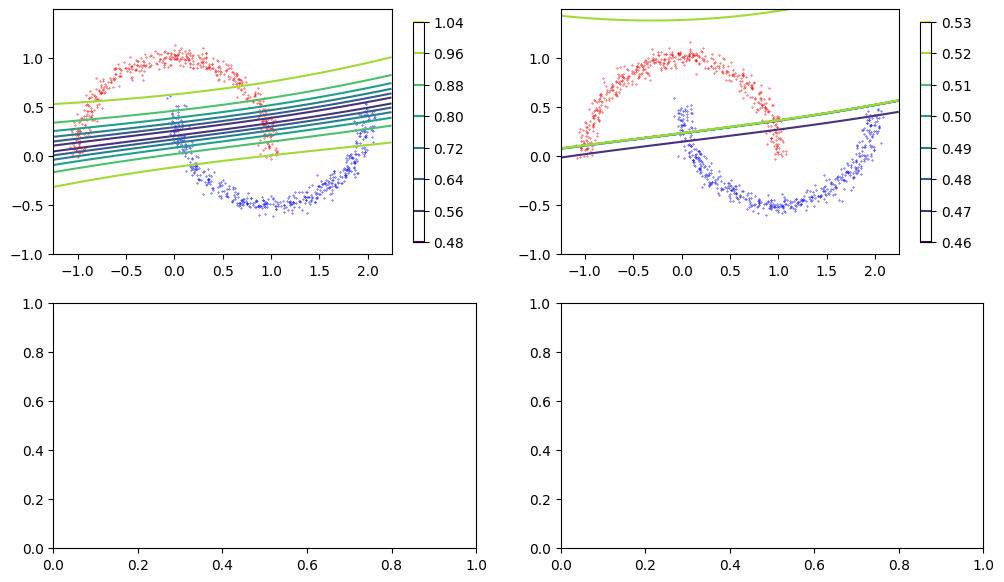

In [159]:

fig, axs = plt.subplots(2, 2,figsize=(12, 7))



cs1 = visualize_db2(axs[0][0],axs[1][0],pl.cur_clf,calib,dm)

cs2 = visualize_db2(axs[0][1],axs[1][1],pl2.cur_clf,calib2,dm2,normalize=False)
fig.colorbar(cs1, ax=axs[0][0], shrink=0.9)
fig.colorbar(cs2, ax=axs[0][1], shrink=0.9)


In [187]:
def visualize_db3(ax,ax_scores_dist,cur_clf, cur_calibrator, dm, normalize=False):

    def get_grid_pts(x_min,x_max, y_min, y_max,step=0.005):
        xx, yy = np.mgrid[x_min:x_max:step, y_min:y_max:step]

        positions = np.vstack([xx.ravel(), yy.ravel()]).T 
        return positions,xx,yy 

    X,xx,yy = get_grid_pts(-1.25,2.25,-1,1.5)
    print(xx.shape,yy.shape)

    Y = torch.zeros(len(X)).long()
    X = torch.Tensor(X)
    X_ = torch.zeros((len(X),2))

    ds = CustomTensorDataset(X=X,Y=Y)
    if(cur_calibrator):
        inf_out = cur_calibrator.predict(ds,inference_conf={"batch_size":100, "device":conf["device"]})
    else:
        inf_out = cur_clf.predict(ds,inference_conf={"batch_size":100, "device":conf["device"]})


    X = safe_to_numpy(X)
    Y = safe_to_numpy(Y)
    g = safe_to_numpy(inf_out['confidence'])
    g[np.isnan(g)]=0.0

       

    y_hat = safe_to_numpy(inf_out['labels'])
    idx = np.arange(0,len(g),1)


    '''
    #idx_ = torch.where((g > 0.45) & (g < 0.55), idx)
    idx_ = idx[(g > 0.48) & (g < 0.52)]

    X_ = X[idx_]
    
    ax.scatter(X_[:,0],X_[:,1],s=0.3)
    '''

    cmap_correct = plt.cm.Greens

    neg_idx = idx[ y_hat==0 ]
    #colors_neg = cmap_neg(0.6*g[neg_idx] / g[neg_idx].max())
    
    g_ = g[neg_idx]
    if(normalize):
        g_ = g_ - min(g_)
        g_ = g_/max(g_)
    g[neg_idx] = g_
    
    pos_idx = idx[ y_hat==1 ]
    
    g_ = g[pos_idx]
    
    if(normalize):
        g_ = g_ - min(g_)
        g_ = g_/max(g_)
    
    g[pos_idx] = g_


    idx_i = idx[y_hat!=Y]

    cmap_i = plt.cm.Reds
    #colors_i = cmap_i(g[idx_i])
    g_ = g[idx_i]*100
    g_ = g_.astype(int)//20
    print(g_)
    colors_i = cmap_i( g_)

    ax.scatter(X[idx_i,0],X[idx_i,1],s=0.1,c=colors_i)

    idx_c = idx[y_hat==Y]
    cmap_c = plt.cm.Greens
    colors_c = cmap_c(g[idx_c])
    ax.scatter(X[idx_c,0],X[idx_c,1],s=0.1,c=colors_c)

    if(cur_calibrator):
        inf_out = cur_calibrator.predict(dm.ds_std_train,inference_conf={"batch_size":100, "device":conf["device"]})
    else:
        inf_out = cur_clf.predict(dm.ds_std_train,inference_conf={"batch_size":100, "device":conf["device"]})

    X,Y = dm.ds_std_train.X ,  dm.ds_std_train.Y
    idx = np.arange(0,len(X),1)
    y_hat = safe_to_numpy(inf_out['labels'])
    print(y_hat.shape,Y.shape)
    Y = safe_to_numpy(Y)
    
    idx_correct = idx[y_hat==Y]
    idx_incorrect = idx[y_hat!=Y]

    pos_idx = idx[ Y==1 ]
    neg_idx = idx[ Y==0 ]

    print(idx_correct.shape)
    idx_c = np.random.choice(idx_correct,500,replace=False)
    idx_i = np.random.choice(idx_incorrect,500,replace=False)

    ax.scatter(X[idx_c,0], X[idx_c,1], color='blue', s=0.1)
    ax.scatter(X[idx_i,0], X[idx_i,1], color='red',  s=0.1)

    
    


(700, 500) (700, 500)


[4 4 4 ... 2 2 2]
(7000,) torch.Size([7000])
(6150,)
(700, 500) (700, 500)
[0 0 0 ... 4 4 4]
(7000,) torch.Size([7000])
(6150,)


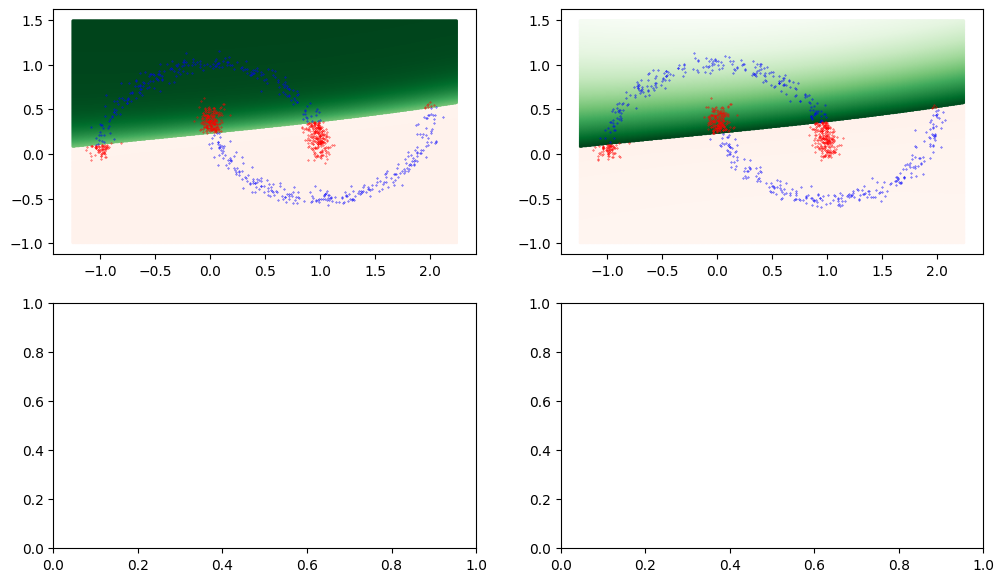

In [188]:

fig, axs = plt.subplots(2, 2,figsize=(12, 7))

visualize_db3(axs[0][0],axs[1][0],pl.cur_clf,calib,dm)

visualize_db3(axs[0][1],axs[1][1],pl2.cur_clf,calib2,dm2,normalize=True)

